In [9]:
import numpy as np

# for the cluster to save the fig:
# import matplotlib
# matplotlib.use('Agg')

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle as sh
from matplotlib import pyplot as plt
import pandas as pd 

import sys

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.datasets import make_classification
#from sklearn.datasets import one_class_data


from sklearn.metrics import auc
from sklearn.covariance import EllipticEnvelope

        



In [10]:
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() -
                          t * (s_unif > u).sum() / n_generated
                          * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        print ('\n failed to achieve t_max \n')
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax


def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt  # sum(s_X > u)
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv

In [11]:
file_path = './REF_Buchungen_2018_Datenset_A.csv'

df = pd.read_csv(file_path ,sep=';',header=None, encoding='ISO-8859-1') 
df.rename({0: 'KtoNr', 4:'Datum', 8:'Umsatz_S', 9:'Umsatz_H', 19:'Anwender'}, axis=1, inplace=True) 
#df.rename({0: 'KtoNr', 6:'Umsatz_S', 7:'Umsatz_H',18:'Anwender'}, axis=1, inplace=True) 
 
# Filtern der Spalten
df= df[['KtoNr','Umsatz_S', 'Umsatz_H', 'Anwender']]

#Handle missing values
df['KtoNr'].dropna(inplace=True)
df['Umsatz_S'].fillna(0, inplace=True)
df['Umsatz_H'].fillna(0, inplace=True)
df['Anwender'].fillna('Unbekannt', inplace=True)

#Filtern der Kontonummern für den Kontenbereich Umsatzerlöse
df = df[((df['KtoNr'] >= 8000) & (df['KtoNr'] <= 8589)) | ((df['KtoNr'] >= 8900) & (df['KtoNr'] <= 8919)) | ((df['KtoNr'] >= 8940) & (df['KtoNr'] <= 8959)) |
   ((df['KtoNr'] >= 8700) & (df['KtoNr'] <= 8799))].copy()


#Datentyptransformationen
df['Umsatz_H'] = df['Umsatz_H'].str.replace(',','.')
df['Umsatz_H'] = pd.to_numeric(df['Umsatz_H'])

df['Umsatz_S'] = df['Umsatz_S'].str.replace(',','.')
df['Umsatz_S'] = pd.to_numeric(df['Umsatz_S'])

df['Anwender'] = df.Anwender.astype('category')
df['Anwender'] = df['Anwender'].cat.codes

#Berechnung des Saldos
df['Saldo'] = df.apply(lambda row: row.Umsatz_H - row.Umsatz_S, axis = 1) 
df = df.drop(columns=['Umsatz_S','Umsatz_H', 'KtoNr'])


indexNames = df[ df['Saldo'] == 0 ].index
df.drop(indexNames , inplace=True)


df_Umsaetze = df
df_Umsaetze.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39480 entries, 1483 to 323769
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Anwender  39480 non-null  int8   
 1   Saldo     39480 non-null  float64
dtypes: float64(1), int8(1)
memory usage: 1.6 MB


IsolationForest processing...
LocalOutlierFactor processing...
OneClassSVM processing...
t ist:  [0.00000000e+00 8.41762781e-10 1.68352556e-09 ... 8.41510252e-06
 8.41594428e-06 8.41678605e-06]
t_max ist :  0.95
volume_support ist:  11879831.5
unif ist:  [[ 1.51025453e+01  2.43277972e+04]
 [ 3.63015182e+01 -4.87214027e+04]
 [ 4.22241534e+01 -7.65093190e+04]
 ...
 [ 3.34691374e-01  8.87296946e+04]
 [ 2.82519472e+01  2.61890502e+04]
 [ 4.68839897e+01 -6.49059116e+04]]

 failed to achieve t_max 

mv_iforest


<ipython-input-12-a5e45a5acf88>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


<Figure size 432x288 with 0 Axes>

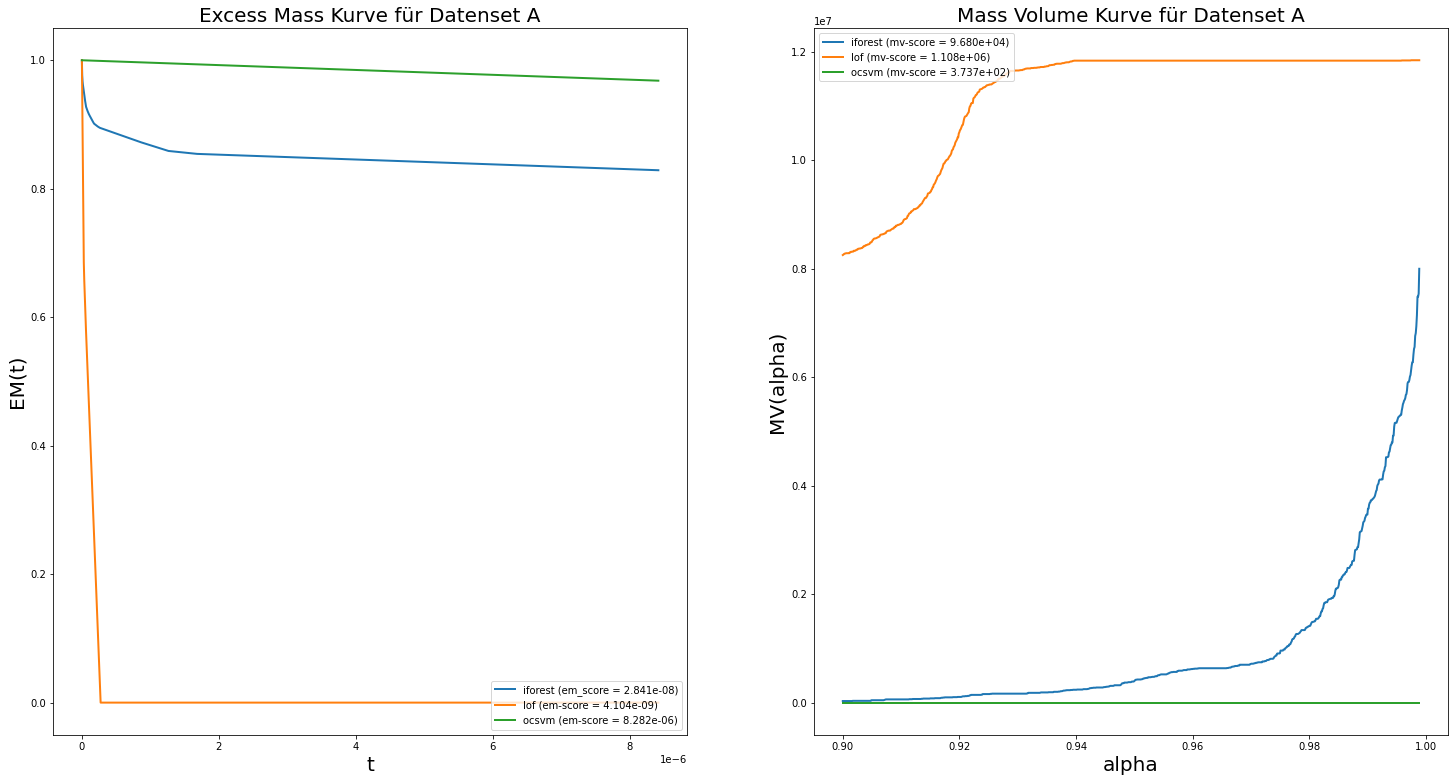

In [12]:
import pandas as pd 


# parameters of the algorithm:
#n_generated = 100000
n_generated = 3144 
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.95
ocsvm_max_train = 10000

np.random.seed(1)

datasets = ['A']

for dat in datasets:
    plt.clf()
    plt.figure(figsize=(25, 13))

    # loading and vectorization
    #X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,n_clusters_per_class=1, weights=[0.999], flip_y=0, random_state=4)
    
    
    X = df.values    
    X.astype(float)
    n_features = 2
    X_train = X#.reshape(-1, 1)
    
    # define models:
    iforest = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.01),max_features=2).fit(X)
    lof = LocalOutlierFactor(n_neighbors=5, novelty=True)
    #ocsvm = OneClassSVM()
    #ocsvm = OneClassSVM(kernel='linear', degree=2, gamma='auto', nu=0.5)
    ocsvm = OneClassSVM(gamma='auto', nu=0.01)

    lim_inf = X.min(axis=0)
    lim_sup = X.max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()
    t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
    axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
    unif = np.random.uniform(lim_inf, lim_sup,
                             size=(n_generated, n_features))

    # fit:
    print('IsolationForest processing...')
    iforest = IsolationForest()
    iforest.fit(X_train)
    s_X_iforest = iforest.decision_function(X_train)
    print('LocalOutlierFactor processing...')
    lof.fit(X_train)
    s_X_lof = lof.decision_function(X_train)

    print('OneClassSVM processing...')
    ocsvm.fit(X_train)
    s_X_ocsvm = ocsvm.decision_function(X_train).reshape(1, -1)[0]
    
    s_unif_iforest = iforest.decision_function(unif)
    s_unif_lof = lof.decision_function(unif)
    s_unif_ocsvm = ocsvm.decision_function(unif).reshape(1, -1)[0]
    plt.subplot(121)
    
    print("t ist: " ,t)
    print("t_max ist : " , t_max)
    print("volume_support ist: " , volume_support)
    print("unif ist: ", unif)
    auc_iforest, em_iforest, amax_iforest = em(t, t_max,
                                               volume_support,
                                               s_unif_iforest,
                                               s_X_iforest, n_generated)

    auc_lof, em_lof, amax_lof = em(t, t_max, volume_support,
                                   s_unif_lof, s_X_lof, n_generated)

    auc_ocsvm, em_ocsvm, amax_ocsvm = em(t, t_max, volume_support,
                                         s_unif_ocsvm, s_X_ocsvm,
                                         n_generated)
    if amax_iforest == -1 or amax_lof == -1 or amax_ocsvm == -1:
        amax = -1
    else:
        amax = max(amax_iforest, amax_lof, amax_ocsvm)
        
    plt.subplot(121)
    plt.plot(t[:amax], em_iforest[:amax], lw=2,
             label='%s (em_score = %0.3e)'
             % ('iforest', auc_iforest))
    plt.plot(t[:amax], em_lof[:amax], lw=2,
             label='%s (em-score = %0.3e)'
             % ('lof', auc_lof))
    plt.plot(t[:amax], em_ocsvm[:amax], lw=2,
             label='%s (em-score = %0.3e)'
             % ('ocsvm', auc_ocsvm))

    plt.ylim([-0.05, 1.05])
    plt.xlabel('t', fontsize=20)
    plt.ylabel('EM(t)', fontsize=20)
    plt.title('Excess Mass Kurve für Datenset ' + dat, fontsize=20)
    plt.legend(loc="lower right")

    plt.subplot(122)
    print ('mv_iforest')
    auc_iforest, mv_iforest = mv(axis_alpha, volume_support,
                                 s_unif_iforest, s_X_iforest, n_generated)
    auc_lof, mv_lof = mv(axis_alpha, volume_support,
                         s_unif_lof, s_X_lof, n_generated)
    auc_ocsvm, mv_ocsvm = mv(axis_alpha, volume_support,
                             s_unif_ocsvm, s_X_ocsvm, n_generated)
    
    
    
    plt.plot(axis_alpha, mv_iforest, lw=2,
             label='%s (mv-score = %0.3e)'
             % ('iforest', auc_iforest))
    plt.plot(axis_alpha, mv_lof, lw=2,
             label='%s (mv-score = %0.3e)'
             % ('lof', auc_lof))
    plt.plot(axis_alpha, mv_ocsvm, lw=2,
             label='%s (mv-score = %0.3e)'
             % ('ocsvm', auc_ocsvm))

    #plt.xlim([-0.05, 1.05])
    #plt.ylim([-0.05, 100])
    plt.xlabel('alpha', fontsize=20)
    plt.ylabel('MV(alpha)', fontsize=20)
    plt.title('Mass Volume Kurve für Datenset ' + dat, fontsize=20)
    plt.legend(loc="upper left",fontsize="medium")

    plt.show()    
    